In [1]:
#import iris
#import Utils.iris_utils as iris_utils
import pandas as pd
import numpy as np
import os
import logging
import esmvalcore.preprocessor
import glob
import warnings
#warnings.filterwarnings("ignore")
import xarray as xr
from xmip.preprocessing import rename_cmip6
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask
import statsmodels.api as sm


## Plan
1. linearly detrend all 3 data sets
2. seasonally detrend all 3 data sets
3. calculate grid-point temporal autocorrelation 

In [2]:

def read_in(dir, t_bnds=None, lat_bnds=None, months=None, last_years=None):
    files = []
    for x in os.listdir(dir): 
        files.append(dir + x)
    #with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    #    ds = rename_cmip6(xr.open_mfdataset(files, parallel=True, chunks={"time": 50}))
    ds = rename_cmip6(xr.open_mfdataset(files))
    if t_bnds:
        ds = ds.sel(time=slice(t_bnds[0], t_bnds[1]))
    if months:
        ds = ds.where((ds['time.month'].isin(months)), drop=True)
    if lat_bnds:
        ds = ds.sel(y=slice(lat_bnds[0],lat_bnds[1]))
    if last_years:
        ds = ds.isel(time=slice(-365*last_years,-1))
    
    #print(dir, ds['time.year'].min().values) #check that only selecting specific time files has worked ok
    return ds


def remove_seasonal_trend(ds):
    return ds.groupby('time.dayofyear') - ds.groupby('time.dayofyear').mean('time')

def remove_linear_trend(ds):
    
    data_detrended = ds.apply(detrend)
    
    out = ds
    return out

# Function to detrend
# Source: https://gist.github.com/rabernat/1ea82bb067c3273a6166d1b1f77d490f
def detrend_dim(ds, dim='time', deg=1, var='tas'):
    """detrend along a single dimension."""
    # calculate polynomial coefficients
    da = ds[var]
    p = da.polyfit(dim=dim, deg=deg, skipna=False)
    # evaluate trend
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    out = da-fit
    # remove the trend
    return out.to_dataset(name=var)


In [4]:
os.listdir('/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/')

['.fileset_info.json',
 '.ftpaccess',
 '00README_catalogue_and_licence.txt',
 'r1i1p1f2']

In [20]:
control_path = '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/day/tas/gn/latest/'
G1_path_1 = '/badc/cmip6/data/CMIP6/GeoMIP/MOHC/UKESM1-0-LL/G1/r1i1p1f2/day/tas/gn/latest/'
G1_path_2 = '/badc/cmip6/data/CMIP6/GeoMIP/MOHC/UKESM1-0-LL/G1/r2i2p1f2/day/tas/gn/latest/'
G1_path_3 = '/badc/cmip6/data/CMIP6/GeoMIP/MOHC/UKESM1-0-LL/G1/r3i2p1f2/day/tas/gn/latest/'
CO2_4x_path = '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/abrupt-4xCO2/r1i1p1f2/day/tas/gn/latest/'

In [21]:
lat_bs, nyears = [-10, 10], 10

# read in, remove seasonal trend, and remove linear trend
control = detrend_dim(remove_seasonal_trend(read_in(control_path, lat_bnds = lat_bs, last_years=nyears)))

G1_1 = detrend_dim(remove_seasonal_trend(read_in(G1_path_1, lat_bnds = lat_bs, last_years=nyears)))
G1_2 = detrend_dim(remove_seasonal_trend(read_in(G1_path_2, lat_bnds = lat_bs, last_years=nyears)))
G1_3 = detrend_dim(remove_seasonal_trend(read_in(G1_path_3, lat_bnds = lat_bs, last_years=nyears)))

CO2_4x = detrend_dim(remove_seasonal_trend(read_in(CO2_4x_path, lat_bnds = lat_bs, last_years=nyears)))


/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/users/a_duffey/.conda/envs/main/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index 

3649


Text(0, 0.5, 'r')

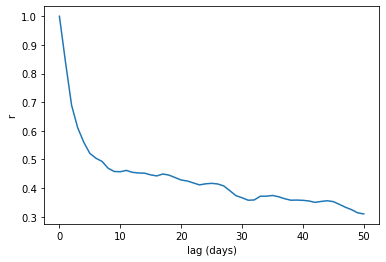

In [152]:
### test for one grid point
i, j = 0, 0
ts = control.isel(x=i, y=j).tas.values

print(len(ts))

# Delay (lag) range that we are interesting in
lags = np.arange(0, 51, 1)
acorr = sm.tsa.acf(ts, nlags = len(lags)-1)
plt.plot(acorr)
plt.xlabel('lag (days)')
plt.ylabel('r')

In [22]:
lags = np.arange(0, 51, 1)


DF = pd.DataFrame(columns=['lag', 'acorr', 'lon', 'lat', 'scenario'])
Scenarios =['piControl', 'G1_1', 'G1_2', 'G1_3', 'abrupt-4xCO2']
s=0
for ds in [control, G1_1, G1_2, G1_3, CO2_4x]:
    ds.load()
    lons, lats = ds.x.values, ds.y.values
    iter=0
    for lon in tqdm(lons):
        for lat in lats:
            ts = ds.sel(x=lon, y=lat).tas.values
            acorr = sm.tsa.acf(ts, nlags = len(lags)-1)
            df = pd.DataFrame({'lag': lags,
                               'acorr': acorr})
            df['lon'] = lon
            df['lat'] = lat
            df['iter'] = iter
            df['scenario'] = Scenarios[s]
            DF = pd.concat([DF, df])
            iter=iter+1
    print(Scenarios[s], ' done')
    s=s+1
    ds.close()

DF.to_csv('autocorrelations_{lat1}_{lat2}_{t}.csv'.format(
            lat1=str(lat_bs[0]), lat2=str(lat_bs[1]), t=nyears))

100%|██████████| 192/192 [00:24<00:00,  7.79it/s]


piControl  done


100%|██████████| 192/192 [00:53<00:00,  3.60it/s]


G1_1  done


100%|██████████| 192/192 [01:23<00:00,  2.30it/s]


G1_2  done


100%|██████████| 192/192 [01:53<00:00,  1.69it/s]


G1_3  done


100%|██████████| 192/192 [02:17<00:00,  1.39it/s]


abrupt-4xCO2  done


In [ ]:
DF[DF['scenario']=='G1']

In [ ]:
DF_g = DF.groupby(['lag', 'scenario'])['acorr'].mean().reset_index()

In [ ]:
DF_g

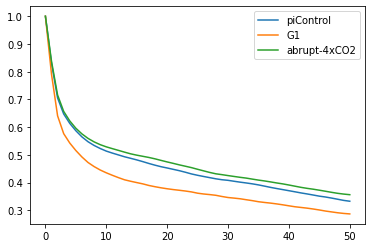

In [7]:
DF = pd.read_csv('autocorrelations.csv')
Scenarios =['piControl', 'G1', 'abrupt-4xCO2']
DF_g = DF.groupby(['lag', 'scenario'])['acorr'].mean().reset_index()
for s in Scenarios:
    DF_plot = DF_g[DF_g['scenario']==s]
    plt.plot(DF_plot['lag'], DF_plot['acorr'], label=s)

plt.legend()
plt.savefig('main_out.png', dpi=300)